# CGAN-DenseNet

**Notes about this specific notebook**

Uses rgb, 64x64 images with ReLU activation and Adam optimizer. No class or sample specific weights are used. Same as cnn-kaggle-v021

This notebook is set up for cross-validation, which is freq. used in research

# Changeable Parameters

_____________________________________________________________________

In [1]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'rgb'

# Batch size
batch_size = 150000

# Number of epochs
epoch_t = 35

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

# Division of the training vs. test set 
test_size = 0.3

# number of folds
n_folds = 10

_____________________________________________________________________

In [2]:
# To check whether the right environment has been selected
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


Import the necessary libraries

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras import datasets, layers, models, losses, Model
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Check whether a, and which GPU is available for the computation

In [4]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Image size
im_si = (ih, iw)

# Convert the color channel to the corresponding number of layers
if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files if computation is done locally

In [6]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/malimg_dataset"
    for files in os.listdir(dir):
        if "cgan-densenet" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: crossv-cgan-densenet-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/malimg_dataset/crossv-cgan-densenet-local-v{new_vnum:03}"
    os.makedirs(new_dir)

1 matches(es) found
--------------
New folder name: crossv-cgan-densenet-local-v021
--------------


**Data**


In [7]:
if cenv == 0:
    path_root = "/kaggle/input/malimgdataset"
    path_root_gen = '/kaggle/input/malimgcganlocalv009woallaple'

if cenv == 1:
    path_root = "C:/Users/Max/Documents/image_data/malimg_paper_dataset_imgs"
    path_root_gen = "C:/Users/Max/Documents/image_data/malimg-cgan-v025-rightsize"

Load the data. No data augmentation takes place

In [8]:
batches = ImageDataGenerator().flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs, labels = next(batches)

Found 9339 images belonging to 25 classes.


Load CGAN generated images

In [9]:
batches_gen = ImageDataGenerator().flow_from_directory(
    directory     = path_root_gen, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs_gen, labels_gen = next(batches_gen)

Found 58507 images belonging to 25 classes.


Original images

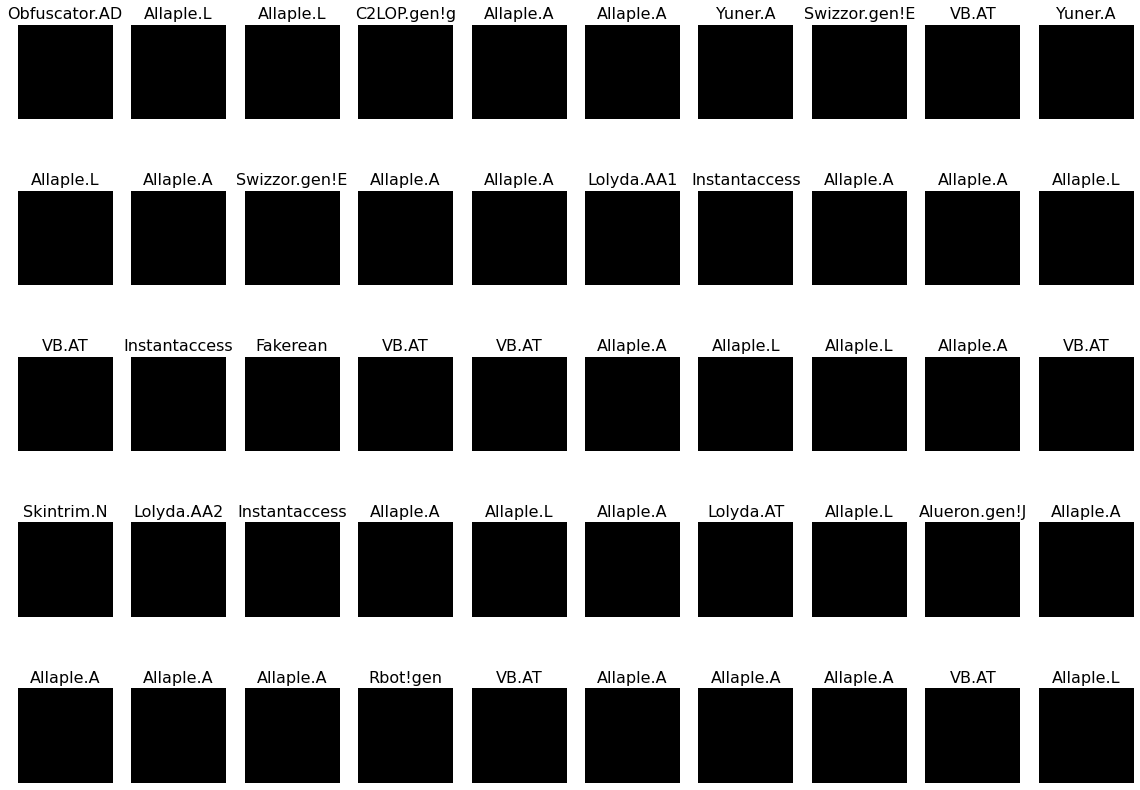

In [22]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs, titles = labels)

Generated images

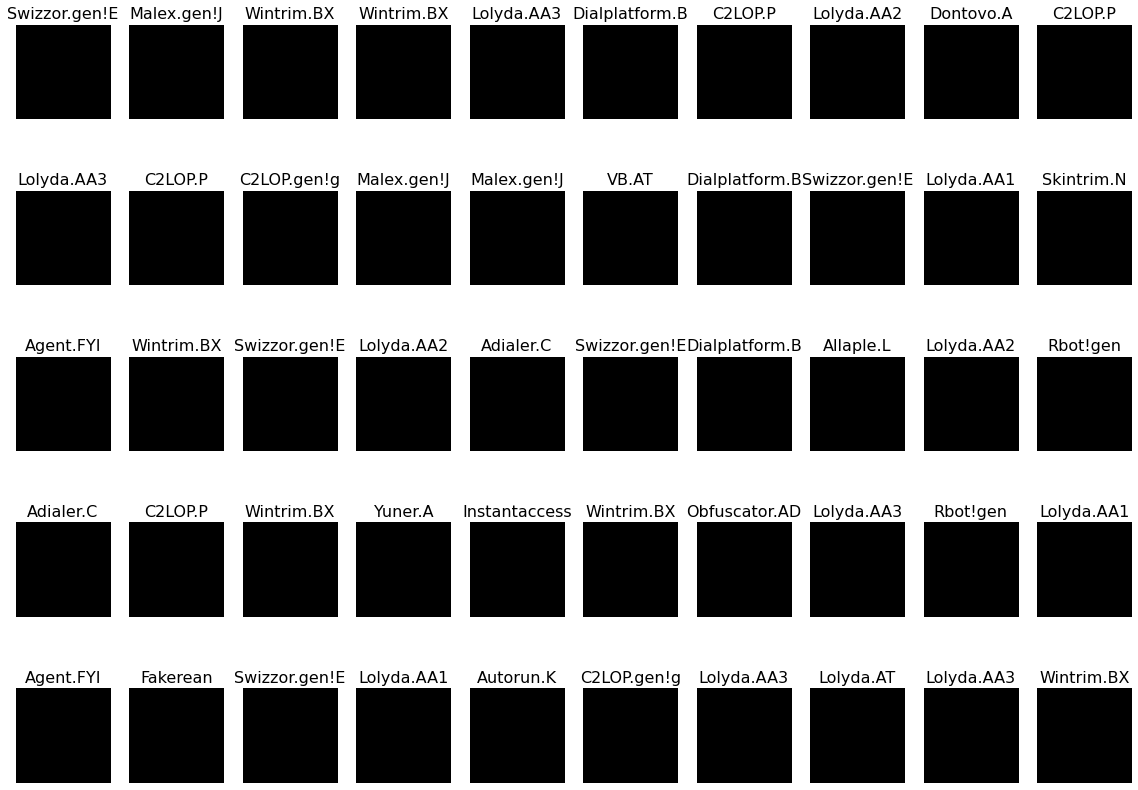

In [23]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs_gen, titles = labels_gen)

In [24]:
# A dictionary of all the different classes
classes = batches.class_indices.keys()
x_axis = np.arange(len(list(classes)))

Plot data distribution among all classes

Standardize images

In [25]:
imgs = imgs / 255.0
imgs_gen = imgs_gen / 255.0

Plot data distribution among train, val. and test set

# CGAN - DenseNet169
We will now build our **DenseNet169** model using Keras. This model will have the following layers :

**Input shape** : 64 * 64 * 3

Nota bene that the DenseNet only takes RGB images (with 3 channels)

In [26]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical

In [27]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

We want **11** classes

In [28]:
num_classes = len(list(batches.class_indices))
print("The number of classes in our dataset: ", num_classes)

The number of classes in our dataset:  25


In [29]:
def confusion_matrix(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):

        df_cm = pd.DataFrame(
            confusion_matrix, index=class_names_bin, columns=class_names_bin, 
        )
        fig = plt.figure(figsize=figsize)
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

class_names_bin= ("ransomware", "benign")

Reduce learning rate after 5 epochs of no improvement on the validition accuracy. Also save save checkpoints for the best performing model based on validation loss

In [30]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)


In [31]:
# Performance metrics
multi_acc_per_fold = []
loss_per_fold = []
multi_f1_per_fold = []
bin_acc_per_fold = []
bin_tpr_per_fold = []
bin_f1_per_fold = []
bin_mcc_per_fold = []

tp = []
fp = []
fn = []
tn = []

# Predictions
y_pred = []
y_true = []

# History
history = []

# Data distribution
train_distr = []
test_distr= []

rw_count = []
bn_count = []

In [32]:
kfold = KFold(n_splits=n_folds, shuffle=True)

Epoch 1/35
1046/1046 [==============================] - 161s 138ms/step - loss: 0.2164 - accuracy: 0.9737 - val_loss: 8.5917 - val_accuracy: 0.1156

Epoch 00001: val_loss improved from inf to 8.59174, saving model to /Users/Max/Documents/GitHub/malimg_dataset/crossv-cgan-densenet-local-v021\model.h5
Epoch 2/35
1046/1046 [==============================] - 142s 136ms/step - loss: 0.0149 - accuracy: 0.9957 - val_loss: 0.1140 - val_accuracy: 0.9582

Epoch 00002: val_loss improved from 8.59174 to 0.11402, saving model to /Users/Max/Documents/GitHub/malimg_dataset/crossv-cgan-densenet-local-v021\model.h5
Epoch 3/35
1046/1046 [==============================] - 142s 135ms/step - loss: 0.1114 - accuracy: 0.9837 - val_loss: 4.5370 - val_accuracy: 0.6413

Epoch 00003: val_loss did not improve from 0.11402
Epoch 4/35
1046/1046 [==============================] - 139s 133ms/step - loss: 0.0372 - accuracy: 0.9934 - val_loss: 0.1153 - val_accuracy: 0.9636

Epoch 00004: val_loss did not improve from 0.

Epoch 1/35
1046/1046 [==============================] - 163s 142ms/step - loss: 0.2383 - accuracy: 0.9686 - val_loss: 4.3022 - val_accuracy: 0.2527

Epoch 00001: val_loss did not improve from 0.06674
Epoch 2/35
1046/1046 [==============================] - 145s 139ms/step - loss: 0.0492 - accuracy: 0.9912 - val_loss: 0.1995 - val_accuracy: 0.9454

Epoch 00002: val_loss did not improve from 0.06674
Epoch 3/35
1046/1046 [==============================] - 145s 139ms/step - loss: 0.0348 - accuracy: 0.9932 - val_loss: 0.1089 - val_accuracy: 0.9690

Epoch 00003: val_loss did not improve from 0.06674
Epoch 4/35
1046/1046 [==============================] - 146s 139ms/step - loss: 0.0325 - accuracy: 0.9932 - val_loss: 0.1530 - val_accuracy: 0.9582

Epoch 00004: val_loss did not improve from 0.06674
Epoch 5/35
1046/1046 [==============================] - 145s 138ms/step - loss: 0.0742 - accuracy: 0.9898 - val_loss: 0.1330 - val_accuracy: 0.9636

Epoch 00005: val_loss did not improve from 0.06674


1046/1046 [==============================] - 143s 137ms/step - loss: 0.0178 - accuracy: 0.9949 - val_loss: 0.0949 - val_accuracy: 0.9732

Epoch 00005: val_loss did not improve from 0.06674
Epoch 6/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0378 - accuracy: 0.9940 - val_loss: 0.1481 - val_accuracy: 0.9518

Epoch 00006: val_loss did not improve from 0.06674
Epoch 7/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0168 - accuracy: 0.9954 - val_loss: 2.8534 - val_accuracy: 0.4615

Epoch 00007: val_loss did not improve from 0.06674
Epoch 8/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0452 - accuracy: 0.9930 - val_loss: 331.2597 - val_accuracy: 0.0385

Epoch 00008: val_loss did not improve from 0.06674
Epoch 9/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0425 - accuracy: 0.9933 - val_loss: 0.0739 - val_accuracy: 0.9775

Epoch 00009: val_loss did not improve from 0.06674
Epoch 10/


Epoch 00008: val_loss did not improve from 0.05367
Epoch 9/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0374 - accuracy: 0.9926 - val_loss: 0.0704 - val_accuracy: 0.9732

Epoch 00009: val_loss did not improve from 0.05367
Epoch 10/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0114 - accuracy: 0.9962 - val_loss: 0.0905 - val_accuracy: 0.9636

Epoch 00010: val_loss did not improve from 0.05367
Epoch 11/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0300 - accuracy: 0.9936 - val_loss: 0.0778 - val_accuracy: 0.9786

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00011: val_loss did not improve from 0.05367
Epoch 12/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.0619 - val_accuracy: 0.9797

Epoch 00012: val_loss did not improve from 0.05367
Epoch 13/35
1046/1046 [==============================] - 141s 13

1046/1046 [==============================] - 141s 135ms/step - loss: 0.0241 - accuracy: 0.9947 - val_loss: 0.1048 - val_accuracy: 0.9636

Epoch 00011: val_loss did not improve from 0.04273
Epoch 12/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 0.1073 - val_accuracy: 0.9690

Epoch 00012: val_loss did not improve from 0.04273
Epoch 13/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0294 - accuracy: 0.9941 - val_loss: 0.1378 - val_accuracy: 0.9593

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00013: val_loss did not improve from 0.04273
Epoch 14/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0090 - accuracy: 0.9970 - val_loss: 0.0943 - val_accuracy: 0.9690

Epoch 00014: val_loss did not improve from 0.04273
Epoch 15/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.1220 -


Epoch 00014: val_loss did not improve from 0.04273
Epoch 15/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0085 - accuracy: 0.9971 - val_loss: 0.1581 - val_accuracy: 0.9540

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00015: val_loss did not improve from 0.04273
Epoch 16/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0064 - accuracy: 0.9977 - val_loss: 0.1000 - val_accuracy: 0.9668

Epoch 00016: val_loss did not improve from 0.04273
Epoch 17/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.1144 - val_accuracy: 0.9657

Epoch 00017: val_loss did not improve from 0.04273
Epoch 18/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.1122 - val_accuracy: 0.9679

Epoch 00018: val_loss did not improve from 0.04273
Epoch 19/35
1046/1046 [==============================] - 141s 1


Epoch 00018: val_loss did not improve from 0.04273
Epoch 19/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.0954 - val_accuracy: 0.9797

Epoch 00019: val_loss did not improve from 0.04273
Epoch 20/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0094 - accuracy: 0.9974 - val_loss: 0.0767 - val_accuracy: 0.9807

Epoch 00020: val_loss did not improve from 0.04273
Epoch 21/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0079 - accuracy: 0.9977 - val_loss: 0.1399 - val_accuracy: 0.9754

Epoch 00021: val_loss did not improve from 0.04273
Epoch 22/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.1717 - val_accuracy: 0.9743

Epoch 00022: val_loss did not improve from 0.04273
Epoch 23/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0115 - accuracy: 0.9974 - val_loss: 0.1396 - val_accuracy: 0.

1046/1046 [==============================] - 141s 135ms/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.0368 - val_accuracy: 0.9882

Epoch 00021: val_loss improved from 0.03785 to 0.03676, saving model to /Users/Max/Documents/GitHub/malimg_dataset/crossv-cgan-densenet-local-v021\model.h5
Epoch 22/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.1860 - val_accuracy: 0.9475

Epoch 00022: val_loss did not improve from 0.03676
Epoch 23/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.0522 - val_accuracy: 0.9882

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00023: val_loss did not improve from 0.03676
Epoch 24/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.0446 - val_accuracy: 0.9893

Epoch 00024: val_loss did not improve from 0.03676
Epoch 25/35
1046/1046 

1046/1046 [==============================] - 141s 135ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0627 - val_accuracy: 0.9829

Epoch 00024: val_loss did not improve from 0.03623
Epoch 25/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.0584 - val_accuracy: 0.9839

Epoch 00025: val_loss did not improve from 0.03623
Epoch 26/35
1046/1046 [==============================] - 142s 136ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.0506 - val_accuracy: 0.9839

Epoch 00026: val_loss did not improve from 0.03623
Epoch 27/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0077 - accuracy: 0.9982 - val_loss: 0.0615 - val_accuracy: 0.9764

Epoch 00027: val_loss did not improve from 0.03623
Epoch 28/35
1046/1046 [==============================] - 141s 135ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0596 - val_accuracy: 0.9829

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0

1046/1046 [==============================] - 140s 134ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0705 - val_accuracy: 0.9807

Epoch 00028: val_loss did not improve from 0.03623
Epoch 29/35
1046/1046 [==============================] - 140s 134ms/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 0.0717 - val_accuracy: 0.9796

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00029: val_loss did not improve from 0.03623
Epoch 30/35
1046/1046 [==============================] - 140s 134ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.0532 - val_accuracy: 0.9829

Epoch 00030: val_loss did not improve from 0.03623
Epoch 31/35
1046/1046 [==============================] - 140s 134ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.0537 - val_accuracy: 0.9829

Epoch 00031: val_loss did not improve from 0.03623
Epoch 32/35
1046/1046 [==============================] - 140s 134ms/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.0592 -

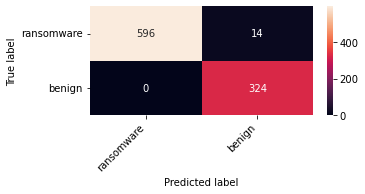

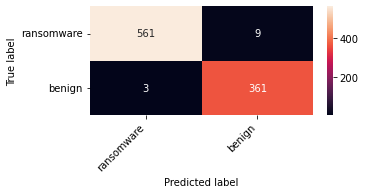

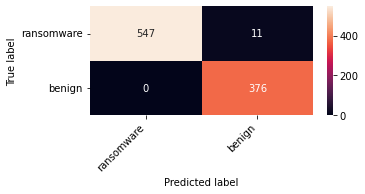

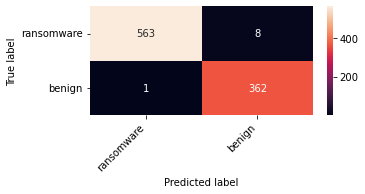

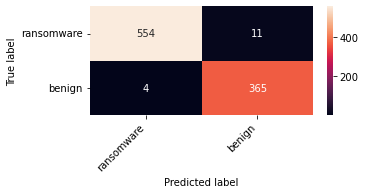

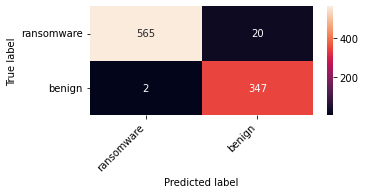

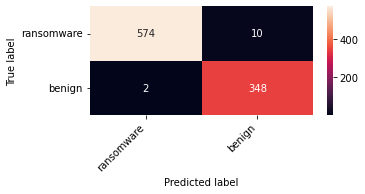

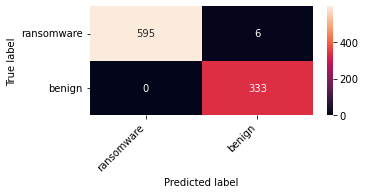

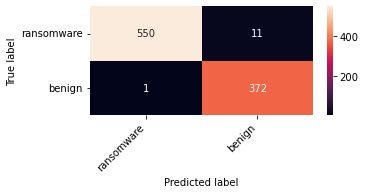

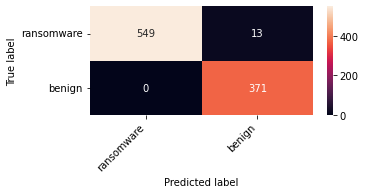

In [34]:
fold_no = 1

for train, test in kfold.split(imgs,labels):
    
    # Add generated images to training data   
    train_images = np.concatenate((imgs[train], imgs_gen), axis = 0)
    train_labels = to_categorical(np.concatenate((np.argmax(labels[train], axis = 1), np.argmax(labels_gen, axis = 1)), axis = 0))

    # DenseNet169
    base_model = tf.keras.applications.DenseNet169(weights = 'imagenet', include_top = False, input_shape = (64,64,3))
    
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(1000, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation = 'softmax')(x)
    
    # Compile the model
    head_model = Model(inputs = base_model.input, outputs = predictions)
    head_model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])
    
    # Freeze all but last eight layers
    for layer in head_model.layers[:-8]:
        layer.trainable=False
    
    for layer in head_model.layers[-8:]:
        layer.trainable=True
    
    # Run the CNN
    history.append(
        head_model.fit(
        train_images, 
        train_labels, 
        validation_data=(imgs[test], labels[test]), 
        epochs=epoch_t,
        callbacks = [anne, checkpoint],
        batch_size = 64) # The actual computation of the CNN
    )
    
    
    
    
    # Generate generalization metrics
    scores = head_model.evaluate(imgs[test], labels[test], verbose=0)
    print(f'Score for fold {fold_no}: {head_model.metrics_names[0]} of {scores[0]}; {head_model.metrics_names[1]} of {scores[1]*100}%')
    multi_acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    # Create two 1D-arrays: one with the prediction per image of the model and one with the true labels
    y_pred = np.append(y_pred, np.argmax(head_model.predict(imgs[test]), axis=-1))
    y_true = np.append(y_true, np.argmax(labels[test], axis=1))
    
    y_pred2 = np.argmax(head_model.predict(imgs[test]), axis=-1)
    y_true2 = np.argmax(labels[test], axis=1)
    
    # Binary
    y_predbin = [] 
    y_truebin = []
    for count, value in enumerate(y_true2):
        if y_true2[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
            y_truebin.append(0)
        else: y_truebin.append(1) # if prediction is not one of the ransomware families, then it is benign

        if y_pred2[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
            y_predbin.append(0)
        else: y_predbin.append(1) # if prediction is not one of the ransomware families, then it is benign
        continue
        
    rw_count.append(len(y_truebin) - np.sum(y_truebin))
    bn_count.append(np.sum(y_truebin))
    
    # Binary confusion Matrix
    c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)
    
    # Plot the confusion matrix
    confusion_matrix(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)
    
    # Save the true/false positives/negatives    
    tp.append(c_matrix_bin[0,0])
    fp.append(c_matrix_bin[0,1])
    fn.append(c_matrix_bin[1,0])
    tn.append(c_matrix_bin[1,1])
    
    # Save the performance metrics used to compare the models
    multi_f1_per_fold.append(f1_score(y_true2, y_pred2, average='macro'))
    bin_tpr_per_fold.append(c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1])) #True Positive Rate
    bin_acc_per_fold.append(accuracy_score(y_truebin, y_predbin)) # Accuracy
    bin_f1_per_fold.append(f1_score(y_truebin, y_predbin, labels=0)) # F1 Score
    bin_mcc_per_fold.append(matthews_corrcoef(y_truebin, y_predbin))  # Matthews Correlation Coefficient
    
    # Save the multi-class data distribution
    train_distr.append((sum(train_labels)/train_labels.shape[0])*100)
    test_distr.append((sum(labels[test])/labels[test].shape[0])*100)    

Cross validation run overview

In [35]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(multi_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {multi_acc_per_fold[i]*100}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(multi_acc_per_fold)*100}% (+- {np.std(multi_acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.08143461495637894 - Accuracy: 97.75160551071167%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.12904441356658936 - Accuracy: 97.53747582435608%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.07455125451087952 - Accuracy: 98.3940064907074%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.05068063735961914 - Accuracy: 98.71520400047302%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.06928674131631851 - Accuracy: 97.64453768730164%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.14328183233737946 - Accuracy: 97.00214266777039%
-------------------------------------------------------------------

# Evaluating performance

Create data distribution graph

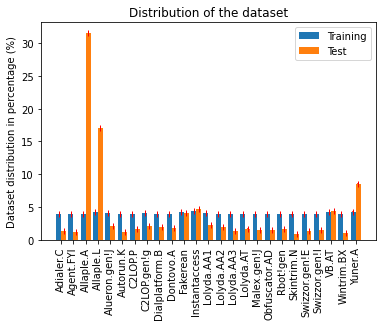

In [36]:
perc_train = np.mean(train_distr, axis = 0)
perc_test =  np.mean(test_distr, axis = 0)

plt.bar(x_axis - 0.2, perc_train, 0.4, label = 'Training')
plt.errorbar(x_axis - 0.2, perc_train, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize = 0)

plt.bar(x_axis + 0.2, perc_test,0.4, label = 'Test')
plt.errorbar(x_axis + 0.2, perc_test, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize=0.0)


plt.title('Distribution of the dataset')
plt.ylabel('Dataset distribution in percentage (%)')
plt.xticks(x_axis, list(classes), rotation='vertical')
plt.legend()

if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight', dpi = 150)

In [37]:
t = PrettyTable(['Metric', 'Performance', 'St.Deviation'])
t.add_row(['M-Class', "", ""])
t.add_row(['Acc    ', round(np.mean(multi_acc_per_fold),4), round(np.std(multi_acc_per_fold),4)])
t.add_row(['Loss   ', round(np.mean(loss_per_fold),4), round(np.std(loss_per_fold),4)])
t.add_row(['Macro F1', round(np.mean(multi_f1_per_fold), 4), round(np.std(multi_f1_per_fold),4)])
t.border = True
t.add_row(['', '', ''])
t.add_row(['B-Class', "", ""])
t.add_row(['TPR    ', round(np.mean(bin_tpr_per_fold),4), round(np.std(bin_tpr_per_fold),4)])
t.add_row(['Acc    ', round(np.mean(bin_acc_per_fold),4), round(np.std(bin_acc_per_fold),4)])
t.add_row(['F1     ', round(np.mean(bin_f1_per_fold),4), round(np.std(bin_f1_per_fold),4)])
t.add_row(['MCC    ', round(np.mean(bin_mcc_per_fold),4), round(np.std(bin_mcc_per_fold),4)])
t.header = True
t.set_style(MSWORD_FRIENDLY)
t.align = "l"
t.title = "Performance of CGAN-DenseNet"
print(t)

+---------------------------------------+
|      Performance of CGAN-DenseNet     |
| Metric   | Performance | St.Deviation |
| M-Class  |             |              |
| Acc      | 0.9806      | 0.0057       |
| Loss     | 0.0844      | 0.0297       |
| Macro F1 | 0.9358      | 0.0096       |
|          |             |              |
| B-Class  |             |              |
| TPR      | 0.9804      | 0.0062       |
| Acc      | 0.9865      | 0.0042       |
| F1       | 0.9826      | 0.0056       |
| MCC      | 0.9718      | 0.0088       |


In [38]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

Evaluate the model based on the test set

Save a table with the performance on the test set

**Evaluating overfitting and other model performance measures**

In [39]:
linecolours = ['gray', 'orange', 'blue', 'green','silver', 'cyan', 'red', 'purple', 'lightgreen', 'black', 'brown']

In [40]:
def eval_metric(model, history, metric_name, ymin, ymax):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    for i in range(n_folds-1):  
        metric = history[i].history[metric_name]
        val_metric = history[i].history['val_' + metric_name]
        e = range(1, epoch_t + 1)
        plt.plot(e, metric, marker = 'o', linestyle = 'none', color = linecolours[i])
        plt.plot(e, val_metric, color = linecolours[i])
        
    metric = history[n_folds-1].history[metric_name]
    val_metric = history[n_folds-1].history['val_' + metric_name]
    e = range(1, epoch_t + 1)
    plt.plot(e, metric, marker = 'o', linestyle = 'none', label = 'Training', color = linecolours[n_folds-1])
    plt.plot(e, val_metric, label = 'Validation', color = linecolours[n_folds-1])
    
    plt.ylim(ymin, ymax)
    
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for CGAN-DenseNet across folds')
    plt.legend()
    if cenv == 0:
        plt.savefig(f"cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)

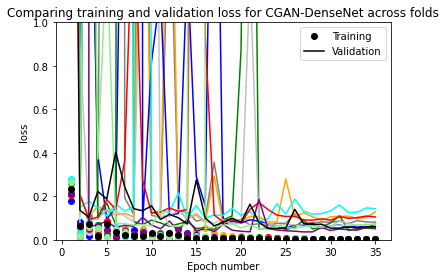

In [41]:
eval_metric(head_model, history, 'loss', 0,1)

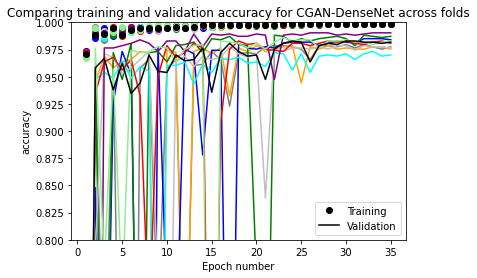

In [42]:
eval_metric(head_model, history, 'accuracy', 0.8,1)

# Confusion Matrix
Analysing the results

# Binary classification
y_predbin and y_testbin are the binary classification arrays. 0 = ransomware and 1 = benign

Plot the distribution of dataset as ransomware - benign

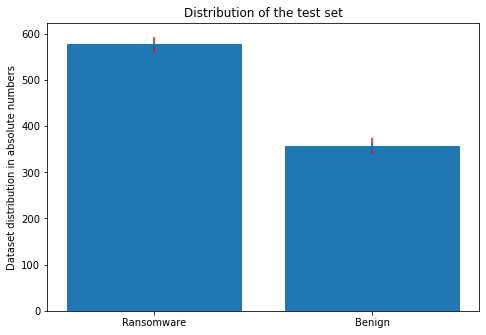

In [43]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [np.mean(rw_count), np.mean(bn_count)]
plt.title('Distribution of the test set')
plt.ylabel('Dataset distribution in absolute numbers')
ax.bar(x_lab, y_lab)
ax.errorbar(x_lab, y_lab, yerr = [np.std(rw_count), np.std(bn_count)], fmt = '|', ecolor='red')
if cenv == 0:
    plt.savefig("bin_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight', dpi = 150)

Plot binary confusion matrix

In [44]:
all_y_predbin = [] 
all_y_truebin = []
for count, value in enumerate(y_true):
    if y_true[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
        all_y_truebin.append(0)
    else: all_y_truebin.append(1) # if prediction is not one of the ransomware families, then it is benign

    if y_pred[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
        all_y_predbin.append(0)
    else: all_y_predbin.append(1) # if prediction is not one of the ransomware families, then it is benign
    continue

In [45]:
def confusion_matrix_bin(confusion_matrix, class_names_bin, name, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f"{(name.capitalize())} Confusion Matrix - CGAN-DenseNet")
    if cenv == 0:
        plt.savefig(f"{name}_cmatrix.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/{name}_cmatrix.png", bbox_inches = 'tight', dpi = 150)

In [46]:
c_matrix_bin = metrics.confusion_matrix(all_y_truebin, all_y_predbin)

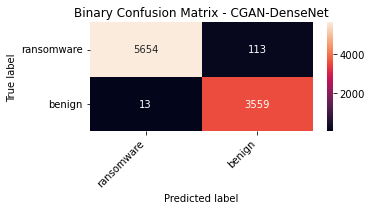

In [47]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, 'binary', figsize = (5,2), fontsize=10)

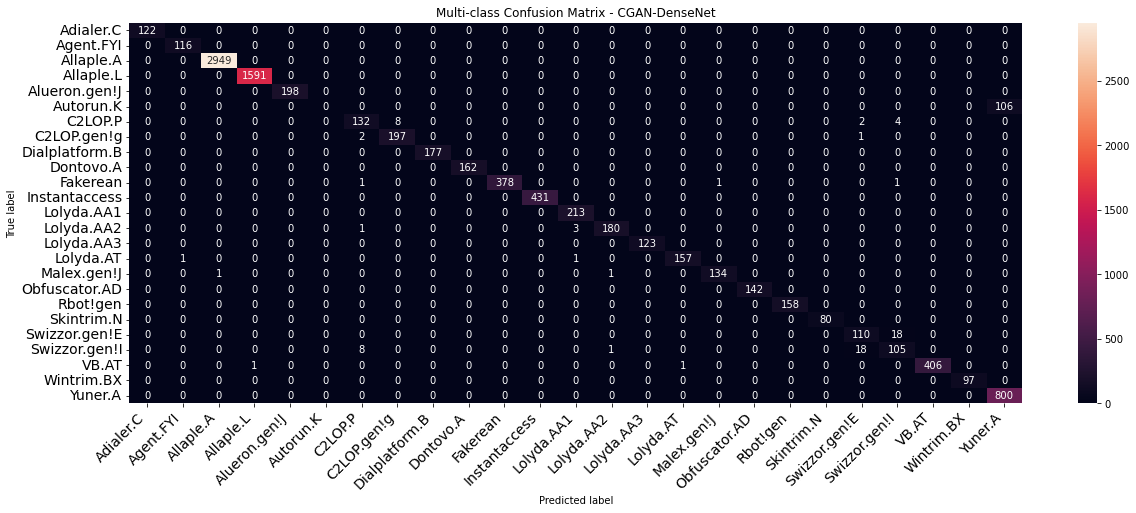

In [48]:
c_matrix = metrics.confusion_matrix(y_true, y_pred)
class_names= batches.class_indices.keys()
confusion_matrix_bin(c_matrix, class_names, 'multi-class', figsize = (20,7), fontsize=14)